## IE 360 Term Project
                                                                                                     Alperen Köksal
                                                                                                     Ekrem Barış Kuyucu

### Introduction

Electricity is used in every part of one's life. Most of the technological devices need electricity in order to perform their functions. EPİAŞ (Enerji Piyasaları İşletme A.Ş.) is a company that provides hourly electricity consumption data of Turkey. In this project, we were expected to forecast the hourly electricity consumption of Turkey.

Historical electricity consumption data from 01 January 2017 were given in dataset. The provided data also included hourly temperature values for 7 different locations that may help to explain the behavior of electricity consumption time series.

In [1]:
library(ggplot2,quietly = TRUE,warn.conflicts = FALSE)
library(forecast,quietly = TRUE,warn.conflicts = FALSE)
library(zoo,quietly = TRUE,warn.conflicts = FALSE)
library(lubridate,quietly = TRUE,warn.conflicts = FALSE)
library(jsonlite,quietly = TRUE,warn.conflicts = FALSE)
library(httr,quietly = TRUE,warn.conflicts = FALSE)
library(data.table,quietly = TRUE,warn.conflicts = FALSE)

get_token <- function(username, password, url_site){
    
    post_body = list(username=username,password=password)
    post_url_string = paste0(url_site,'/token/')
    result = POST(post_url_string, body = post_body)

    # error handling (wrong credentials)
    if(result$status_code==400){
        print('Check your credentials')
        return(0)
    }
    else if (result$status_code==201){
        output = content(result)
        token = output$key
    }

    return(token)
}

get_data <- function(start_date='2020-03-20', token, url_site){
    
    post_body = list(start_date=start_date,username=username,password=password)
    post_url_string = paste0(url_site,'/dataset/')
    
    header = add_headers(c(Authorization=paste('Token',token,sep=' ')))
    result = GET(post_url_string, header, body = post_body)
    output = content(result)
    data = data.table::rbindlist(output)
    data[,event_date:=as.Date(event_date)]
    data = data[order(event_date)]
    return(data)
}


send_submission <- function(predictions, token, url_site, submit_now=F){
    
    format_check=check_format(predictions)
    if(!format_check){
        return(FALSE)
    }
    
    post_string="list("
    for(i in 1:nrow(predictions)){
        if(i<nrow(predictions)){
            post_string=sprintf("%s%s,",post_string,predictions$forecast[i])
        } else {
            post_string=sprintf("%s%s)",post_string,predictions$forecast[i])
        }
    }
    
    submission = eval(parse(text=post_string))
    json_body = jsonlite::toJSON(submission, auto_unbox = TRUE)
    submission=list(submission=json_body)
    
    print(submission)
    # {"31515569":2.4,"32939029":2.4,"4066298":2.4,"6676673":2.4,"7061886":2.4,"85004":2.4} 

    if(!submit_now){
        print("You did not submit.")
        return(FALSE)      
    }
    

    header = add_headers(c(Authorization=paste('Token',token,sep=' ')))
    post_url_string = paste0(url_site,'/submission/')
    result = POST(post_url_string, header, body=submission)
    
    if (result$status_code==201){
        print("Successfully submitted. Below you can see the details of your submission")
    } else {
        print("Could not submit. Please check the error message below, contact the assistant if needed.")
    }
    
    print(content(result))
    
}

check_format <- function(predictions){
    
    if(is.data.frame(predictions) | is.data.frame(predictions)){
        if('forecast' %in% names(predictions)){
            if(nrow(predictions)==24){
                if(all(is.numeric(predictions$forecast))){
                    print("Format OK")
                    return(TRUE)
                } else {
                    print("forecast information is not numeric")
                    return(FALSE)                
                }
            } else {
                print("Forecasts for 24 hours should be provided, current number of rows:")
                print(nrow(predictions))
                return(FALSE)     
            }
        } 
    } else {
        print("Wrong format. Please provide data.frame or data.table object")
        return(FALSE)
    }
    
}

# this part is main code
subm_url = 'http://46.101.124.77'

u_name = "Group7"
p_word = "QofZvHEbYhRpN6Qv"
submit_now = FALSE

username = u_name
password = p_word

token = get_token(username=u_name, password=p_word, url=subm_url)
data = get_data(token=token,url=subm_url)

# this part is where you need to provide your forecasting function / or set of R codes
predictions=data.table(Date=rep(as.Date(Sys.time())+1,24),Hour=0:23)
# be sure if ordered
predictions=predictions[order(Date,Hour)]
# dummy forecast
predictions[,forecast:=1:24]

#send_submission(predictions, token, url=subm_url, submit_now=F)
    

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



### Reading and manipulating the data

bulk data provided by EPİAŞ is read and it is merged with the data provided by api. Some related variables are added to data table to use in basic linear regression model to find outliers and using in ARIMAX model.

In [2]:
setwd("C:/Users/a_kok/Desktop/Dersler/IE 360/Project")
consumption_and_temp <- fread("consumption_and_temp.csv")
consumption_and_temp[,Date:=as.Date(Date)]
data = data[order(event_date,event_hour)]
setnames(data,c("event_date","event_hour","consumption","t_1","t_2","t_3","t_4","t_5","t_6","t_7"),
                c("Date","Hour","Consumption","T_1","T_2","T_3","T_4","T_5","T_6","T_7"))
consumption_and_temp <- rbind(consumption_and_temp,data)
consumption_and_temp[,weekdays:=weekdays(Date)]
consumption_and_temp[,months:=as.factor(month(Date))]
consumption_and_temp[,years:=year(Date)]
consumption_and_temp[,trend:=1:.N]
consumption_and_temp[,T_mean:=mean(c(T_1,T_2,T_3,T_4,T_5,T_6,T_7)),by = list(Date)]
consumption_and_temp[,T_diff:=T_mean - shift(T_mean,24)]
consumption_and_temp[,T1_max:=max(T_1),by = list(Date)]
consumption_and_temp[,T2_max:=max(T_2),by = list(Date)]
consumption_and_temp[,T3_max:=max(T_3),by = list(Date)]
consumption_and_temp[,T4_max:=max(T_4),by = list(Date)]
consumption_and_temp[,T5_max:=max(T_5),by = list(Date)]
consumption_and_temp[,T6_max:=max(T_6),by = list(Date)]
consumption_and_temp[,T7_max:=max(T_7),by = list(Date)]
consumption_and_temp[,T3_diff:=T3_max - shift(T3_max,24)]
consumption_and_temp[,T7_diff:=T7_max - shift(T7_max,24)]
consumption_and_temp[,T3_diff_168:=T3_max - shift(T3_max,168)]
consumption_and_temp[,timestamp:=ymd_h(paste(Date,Hour))]

In [3]:
consumption_and_temp_train = consumption_and_temp[Date < "2021-01-30"]

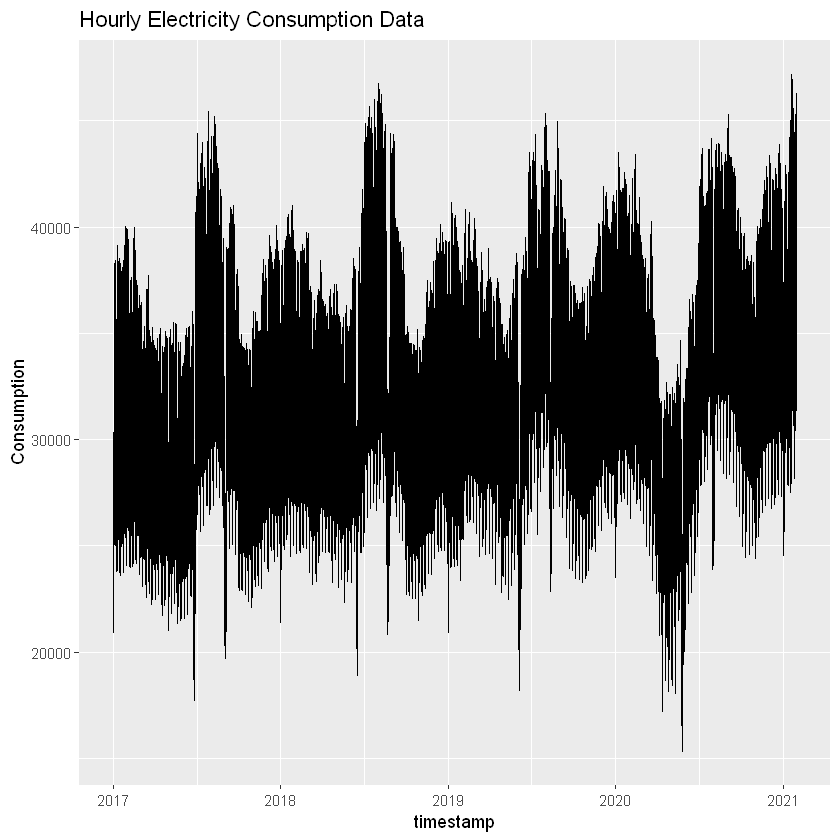

In [4]:
ggplot(data = consumption_and_temp_train,aes(x=timestamp, y = Consumption)) + geom_line() +
labs(title = "Hourly Electricity Consumption Data")

## Effect of temperature

When we plot electricity data and temperature values, relationship between consumption and temperature is observed. From the plot there can be seen that when temperature is between 20 and 30 degrees, consumption is observed less than other temperature values. The reason for this is that people tend to consume electricity for getting warmer or cooler, when temperature is not in this interval. So it is a good idea to use temperature values in the model.

In this case using T3_max is the best option since its coefficient is lowest and it seems to explain the behavior of data better than other measures. It is decided by using each of them in linear regression models and comparing R squared values. Also maximum of daily temperature values are used since using hourly temperature values can be misleading.


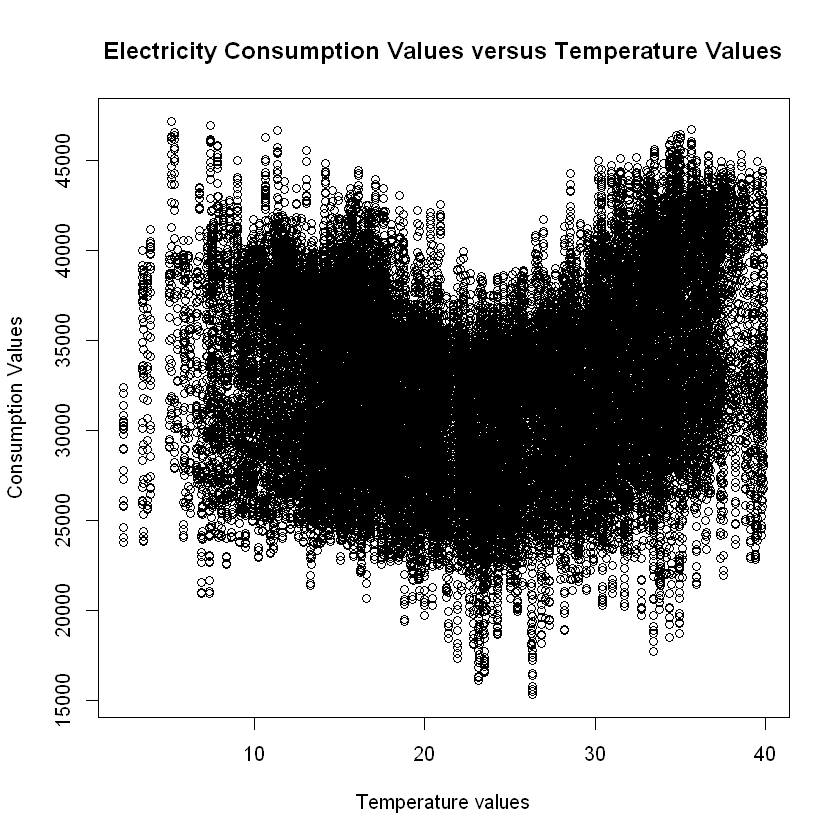

In [5]:
plot(y = consumption_and_temp_train$Consumption,x = consumption_and_temp_train$T3_max,
    main = "Electricity Consumption Values versus Temperature Values",
    xlab = "Temperature values", ylab = "Consumption Values")

In [6]:
fit <- lm(Consumption~T1_max,consumption_and_temp_train)

summary(fit)

fit <- lm(Consumption~T2_max,consumption_and_temp_train)

summary(fit)

fit <- lm(Consumption~T3_max,consumption_and_temp_train)

summary(fit)

fit <- lm(Consumption~T4_max,consumption_and_temp_train)

summary(fit)

fit <- lm(Consumption~T5_max,consumption_and_temp_train)

summary(fit)

fit <- lm(Consumption~T6_max,consumption_and_temp_train)

summary(fit)

fit <- lm(Consumption~T7_max,consumption_and_temp_train)

summary(fit)


Call:
lm(formula = Consumption ~ T1_max, data = consumption_and_temp_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-17396.0  -3874.5     30.8   3698.1  15545.9 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 31736.827     51.054  621.63   <2e-16 ***
T1_max         55.289      2.996   18.46   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5040 on 35758 degrees of freedom
Multiple R-squared:  0.009436,	Adjusted R-squared:  0.009408 
F-statistic: 340.6 on 1 and 35758 DF,  p-value: < 2.2e-16



Call:
lm(formula = Consumption ~ T2_max, data = consumption_and_temp_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-17311.7  -3885.5     26.9   3685.7  15268.4 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 31461.004     79.596   395.3   <2e-16 ***
T2_max         42.682      2.965    14.4   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5049 on 35758 degrees of freedom
Multiple R-squared:  0.005762,	Adjusted R-squared:  0.005735 
F-statistic: 207.2 on 1 and 35758 DF,  p-value: < 2.2e-16



Call:
lm(formula = Consumption ~ T3_max, data = consumption_and_temp_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-17404.8  -3870.0     33.7   3703.2  15757.4 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 31117.40      76.49  406.82   <2e-16 ***
T3_max         61.53       3.10   19.85   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5036 on 35758 degrees of freedom
Multiple R-squared:  0.0109,	Adjusted R-squared:  0.01087 
F-statistic: 393.9 on 1 and 35758 DF,  p-value: < 2.2e-16



Call:
lm(formula = Consumption ~ T4_max, data = consumption_and_temp_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-17249.4  -3891.4     33.9   3674.7  15442.4 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 31898.440     54.729  582.85   <2e-16 ***
T4_max         37.703      2.805   13.44   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5051 on 35758 degrees of freedom
Multiple R-squared:  0.005027,	Adjusted R-squared:  0.004999 
F-statistic: 180.7 on 1 and 35758 DF,  p-value: < 2.2e-16



Call:
lm(formula = Consumption ~ T5_max, data = consumption_and_temp_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-17163.2  -3897.2     36.8   3674.5  15470.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 31904.601     58.176   548.4   <2e-16 ***
T5_max         35.547      2.889    12.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5053 on 35758 degrees of freedom
Multiple R-squared:  0.004217,	Adjusted R-squared:  0.004189 
F-statistic: 151.4 on 1 and 35758 DF,  p-value: < 2.2e-16



Call:
lm(formula = Consumption ~ T6_max, data = consumption_and_temp_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-17278.4  -3895.8     29.6   3676.4  15520.2 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 31889.244     53.544  595.57   <2e-16 ***
T6_max         39.181      2.792   14.03   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5050 on 35758 degrees of freedom
Multiple R-squared:  0.005477,	Adjusted R-squared:  0.005449 
F-statistic: 196.9 on 1 and 35758 DF,  p-value: < 2.2e-16



Call:
lm(formula = Consumption ~ T7_max, data = consumption_and_temp_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-17136.5  -3871.4     30.5   3693.9  15858.2 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 31219.394     71.499  436.64   <2e-16 ***
T7_max         70.053      3.519   19.91   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5036 on 35758 degrees of freedom
Multiple R-squared:  0.01096,	Adjusted R-squared:  0.01094 
F-statistic: 396.4 on 1 and 35758 DF,  p-value: < 2.2e-16


## Outlier analysis

When the electricity data is plotted, there were seen that some points are very different from the usual pattern of the data. With the use of a basic linear regression model, these points are found and analyzed. If the reason of this behavior is known, a dummy variable is given to the outlier point in order to eliminate the effect of these outlier points in predictions. From basic knowledge it is thought that special holidays may be the reason of these outlier points, such as: New year's eve, Ramadan fest, Kurban fest. 

It is known that outliers with lower values are these special holidays. For the outliers with higher values reasons are harder to find. So a dummy variable is given for all values that are bigger than %99 of residuals of basic linear regression model. 

In [7]:
fit <- lm(Consumption~as.factor(Hour) + weekdays + months + years + T3_max,consumption_and_temp_train)

consumption_and_temp_train[,residuals := residuals(fit)]
consumption_and_temp_train[,residuals := mean(residuals), by = Date]
consumption_and_temp_train[year(Date) == 2017 & residuals < quantile(residuals,0.05),unique(Date)]
consumption_and_temp_train[year(Date) == 2018 & residuals < quantile(residuals,0.05),unique(Date)]
consumption_and_temp_train[year(Date) == 2019 & residuals < quantile(residuals,0.05),unique(Date)]
consumption_and_temp_train[year(Date) == 2020 & residuals < quantile(residuals,0.05),unique(Date)]

[1] "2017-06-25" "2017-06-26" "2017-06-27" "2017-08-30" "2017-08-31"
[6] "2017-09-01" "2017-09-02" "2017-09-03" "2017-09-04"

[1] "2018-01-01" "2018-06-14" "2018-06-15" "2018-06-16" "2018-08-20"
 [6] "2018-08-21" "2018-08-22" "2018-08-23" "2018-08-24" "2018-08-25"
[11] "2018-10-29"

[1] "2019-01-01" "2019-06-03" "2019-06-04" "2019-06-05" "2019-06-06"
 [6] "2019-06-07" "2019-07-15" "2019-08-10" "2019-08-11" "2019-08-12"
[11] "2019-08-13" "2019-08-14" "2019-10-29"

[1] "2020-01-01" "2020-03-31" "2020-04-07" "2020-04-08" "2020-04-09"
 [6] "2020-04-10" "2020-04-11" "2020-04-12" "2020-04-13" "2020-04-14"
[11] "2020-04-15" "2020-04-16" "2020-04-17" "2020-04-18" "2020-04-19"
[16] "2020-04-20" "2020-04-23" "2020-04-24" "2020-04-25" "2020-04-26"
[21] "2020-04-29" "2020-04-30" "2020-05-01" "2020-05-02" "2020-05-09"
[26] "2020-05-10" "2020-05-19" "2020-05-23" "2020-05-24" "2020-05-25"
[31] "2020-05-26" "2020-05-27" "2020-05-30" "2020-07-15" "2020-07-30"
[36] "2020-07-31" "2020-08-01" "2020-08-02" "2020-08-03"

In [8]:
newyear_dates = c("2017-01-01","2018-01-01","2018-12-31","2019-01-01","2020-01-01","2021-01-01","2021-01-02")

ramadan_dates = c("2017-06-24","2017-06-25","2017-06-26","2017-06-27","2018-06-14","2018-06-15","2018-06-16","2018-06-17",
                 "2019-06-03","2019-06-04","2019-06-05","2019-06-06","2019-06-07","2020-05-23","2020-05-24","2020-05-25",
                 "2020-05-26","2020-05-27")

kurban_dates = c("2017-08-30","2017-08-31","2017-09-01","2017-09-02","2017-09-03","2017-09-04","2018-08-20","2018-08-21",
                "2018-08-22","2018-08-23","2018-08-24","2018-08-25","2019-08-10","2019-08-11","2019-08-12","2019-08-13",
                "2019-08-14","2020-07-30","2020-07-31","2020-08-01","2020-08-02","2020-08-03")

holidays = c("2018-10-29","2019-05-01","2019-07-15","2019-10-29","2020-05-19","2020-07-15")

corona_period = c("2020-04-07","2020-04-08","2020-04-09","2020-04-10","2020-04-11","2020-04-12","2020-04-13","2020-04-14",
                 "2020-04-15","2020-04-16","2020-04-17","2020-04-18","2020-04-19","2020-04-20","2020-04-23","2020-04-24",
                  "2020-04-25","2020-04-30","2020-05-01","2020-05-02","2020-05-09","2020-05-30")
consumption_and_temp_train[,newyear:= 0]
consumption_and_temp_train[Date %in% as.Date(newyear_dates),newyear:=1]

consumption_and_temp_train[,ramadan:= 0]
consumption_and_temp_train[Date %in% as.Date(ramadan_dates),ramadan:=1]

consumption_and_temp_train[,kurban:= 0]
consumption_and_temp_train[Date %in% as.Date(kurban_dates),kurban:=1]

consumption_and_temp_train[,holiday:= 0]
consumption_and_temp_train[Date %in% as.Date(holidays),holiday:=1]

consumption_and_temp_train[,corona:= 0]
consumption_and_temp_train[Date %in% as.Date(corona_period),corona:=1]
consumption_and_temp_train[year(Date) == 2020 & month(Date) == 4,corona:=1]


In [9]:
fit <- lm(Consumption~as.factor(Hour) + weekdays + months + years + T3_max + newyear +
          kurban + ramadan + holiday + corona,consumption_and_temp_train)

consumption_and_temp_train[,residuals := residuals(fit)]
consumption_and_temp_train[,outlier_big:=0]
consumption_and_temp_train[residuals > quantile(residuals,0.99),outlier_big:=1]

### Differencing

The consumption data is not stationary which is seen from unit root test. To get a stationary data for accurate predictions, daily and weekly differencing methods are used since there can be seen that from autocorrelation plot that there are strong correlations at lag 24 and 168 which corresponds to one day and one week. After using differencing method obtained differenced values may be said to be stationary according to unit root test. By comparing daily and weekly differencing, weekly differencing is chosen because using daily differencing does not provide good prediction results since when two days ahead forecasting is done, the error of first day is added to prediction of second day. 




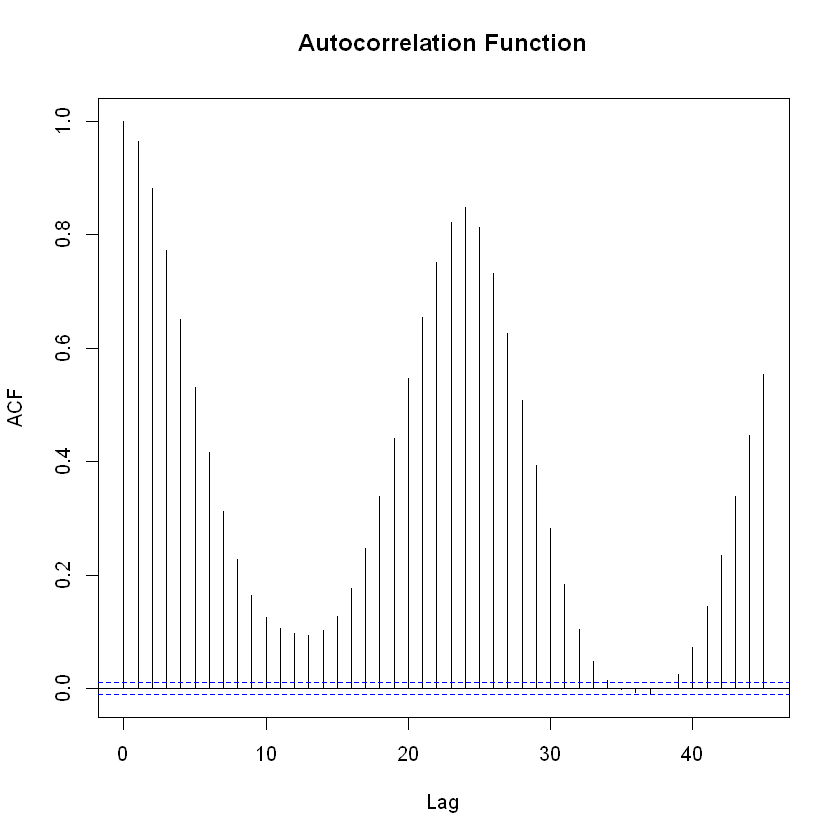

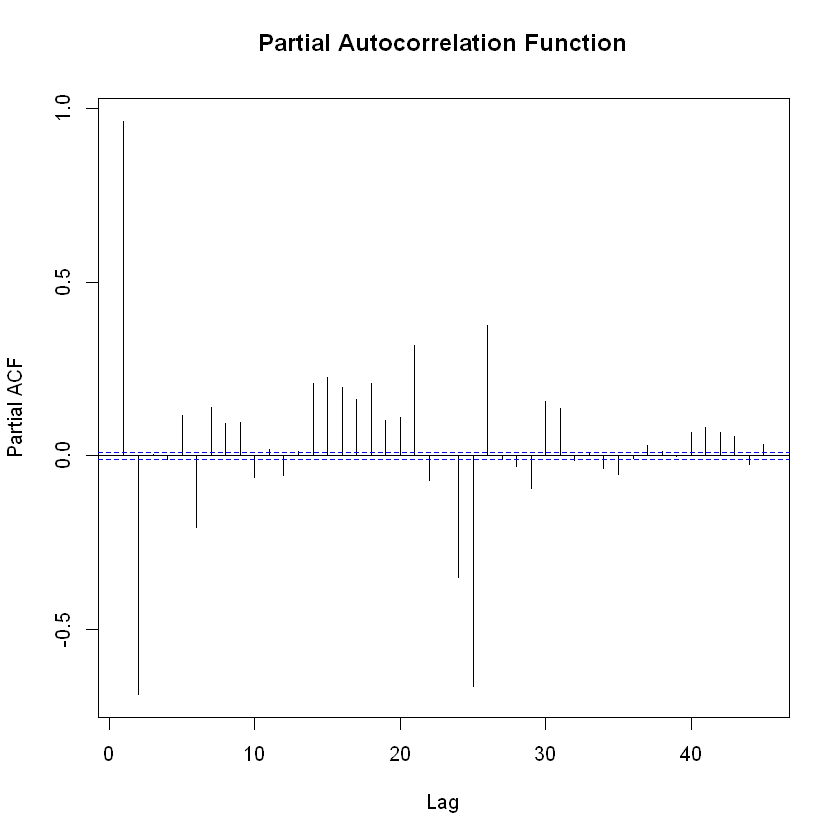

In [10]:
acf(consumption_and_temp_train$Consumption,main = "Autocorrelation Function")
pacf(consumption_and_temp_train$Consumption,main = "Partial Autocorrelation Function")

In [11]:
require(urca)
unt_test=ur.kpss(consumption_and_temp_train$Consumption) 
summary(unt_test)

Loading required package: urca




####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 17 lags. 

Value of test-statistic is: 10.6481 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


In [12]:
consumption_and_temp_train[,differ:= Consumption - shift(Consumption,24)]
unt_test=ur.kpss(consumption_and_temp_train$differ) 
summary(unt_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 17 lags. 

Value of test-statistic is: 0.0033 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


In [13]:
consumption_and_temp_train[,differ_168:= Consumption - shift(Consumption,168)]
unt_test=ur.kpss(consumption_and_temp_train$differ_168) 
summary(unt_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 17 lags. 

Value of test-statistic is: 0.0807 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


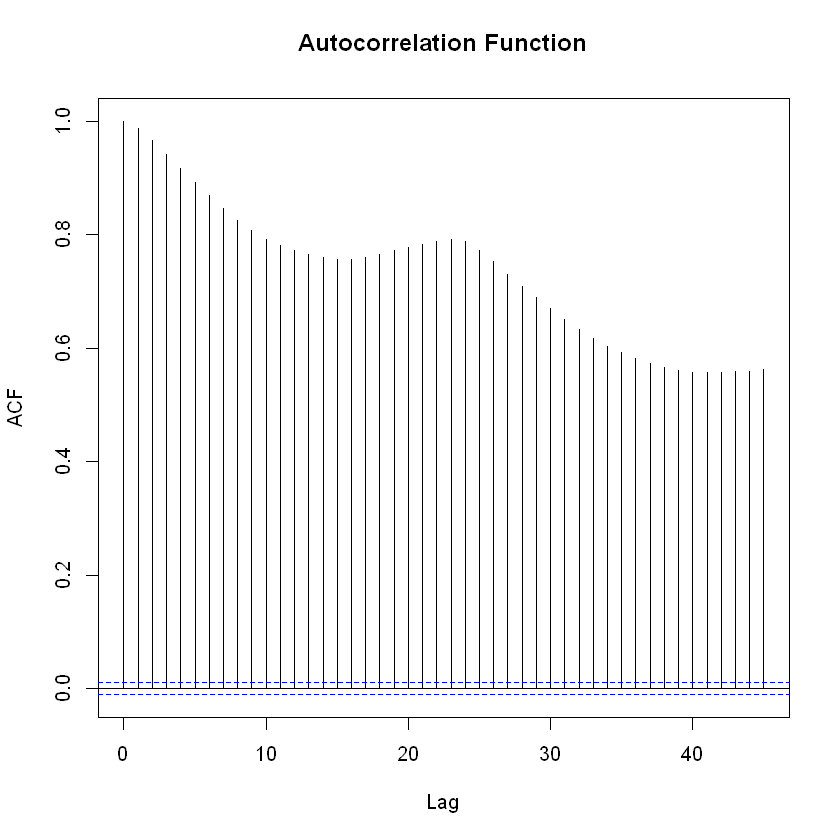

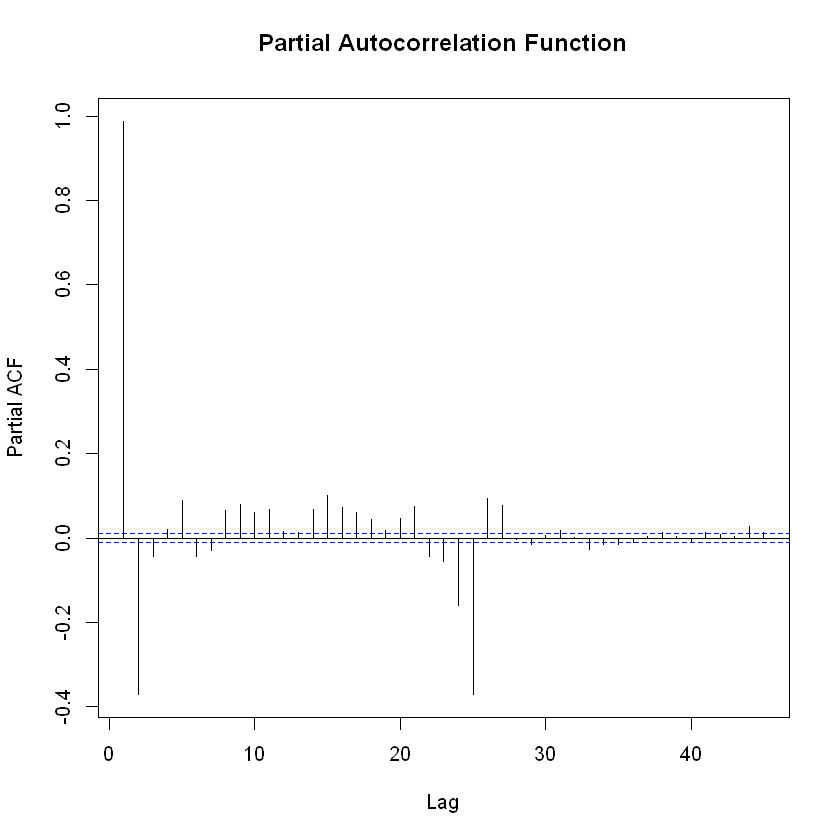

In [14]:
acf(consumption_and_temp_train$differ_168,na.action = na.pass,main = "Autocorrelation Function")
pacf(consumption_and_temp_train$differ_168,na.action = na.pass,main = "Partial Autocorrelation Function")

### ARIMAX

When looking to the autocorrelation and partial autocorrelation functions of differenced values, there can be seen that there are strong correlations at some lags. So ARIMA model is decided to use in this project. Temperature and dummy variables for outliers also may help the model to explain the behavior of data so they are used with ARIMAX model. In order to use them, they are also weekly differed since model is created using weekly differenced electricity consumption values. With the help of these regressors and using "auto.arima" function, a model is fitted for each day with the lowest AIC value to use in forecasting.

With those models two days ahead forecasts are performed. Forecasted differenced values are transformed to electricity consumption values. WMAPE values are computed for forecasted values. 

In [15]:
consumption_and_temp_train[,dnewyear:= newyear - shift(newyear,168)]
consumption_and_temp_train[,dramadan:= ramadan - shift(ramadan,168)]
consumption_and_temp_train[,dkurban:= kurban - shift(kurban,168)]
consumption_and_temp_train[,dholiday:= holiday - shift(holiday,168)]
consumption_and_temp_train[,dcorona:= corona - shift(corona,168)]
consumption_and_temp_train[,doutlier_big := outlier_big - shift(outlier_big,168)]

In [16]:
accu = function(actual, forecast){
    n = length(actual)
    error = actual - forecast
    mean = mean(actual)
    sd = sd(actual)
    FBias = sum(error)/sum(actual)
    MAPE = sum(abs(error/actual)) / n
    RMSE = sqrt(sum(error^2) / n)
    MAD = sum(abs(error)) / n
    WMAPE = MAD / mean
    l = data.frame(n, mean, sd, FBias, MAPE, RMSE, MAD, WMAPE)
    return(l)
}

In [17]:
reg_matrix = cbind(consumption_and_temp_train$dnewyear,consumption_and_temp_train$dkurban,consumption_and_temp_train$dramadan,
                  consumption_and_temp_train$dcorona,consumption_and_temp_train$dholiday,consumption_and_temp_train$doutlier_big,
                  consumption_and_temp_train$T3_diff_168)

An iterative program to perform 15 days forecast with updating model on train data and updating regressors each day. At the end it will record forecasted values and print WMAPE values for each day

In [18]:
forecasted_arimax <- c()
for(i in 0:14){
consumption_and_temp_train = consumption_and_temp[Date < (as.Date("2021-01-29") + i)]

consumption_and_temp_train[,newyear:= 0]
consumption_and_temp_train[Date %in% as.Date(newyear_dates),newyear:=1]

consumption_and_temp_train[,ramadan:= 0]
consumption_and_temp_train[Date %in% as.Date(ramadan_dates),ramadan:=1]

consumption_and_temp_train[,kurban:= 0]
consumption_and_temp_train[Date %in% as.Date(kurban_dates),kurban:=1]

consumption_and_temp_train[,holiday:= 0]
consumption_and_temp_train[Date %in% as.Date(holidays),holiday:=1]

consumption_and_temp_train[,corona:= 0]
consumption_and_temp_train[Date %in% as.Date(corona_period),corona:=1]
consumption_and_temp_train[year(Date) == 2020 & month(Date) == 4,corona:=1]

fit <- lm(Consumption~as.factor(Hour) + weekdays + months + years + T3_max + newyear +
          kurban + ramadan + holiday + corona,consumption_and_temp_train)

consumption_and_temp_train[,residuals := residuals(fit)]
consumption_and_temp_train[,outlier_big:=0]
consumption_and_temp_train[residuals > quantile(residuals,0.99),outlier_big:=1]

consumption_and_temp_train[,differ_168:= Consumption - shift(Consumption,168)]
consumption_and_temp_train[,dnewyear:= newyear - shift(newyear,168)]
consumption_and_temp_train[,dramadan:= ramadan - shift(ramadan,168)]
consumption_and_temp_train[,dkurban:= kurban - shift(kurban,168)]
consumption_and_temp_train[,dholiday:= holiday - shift(holiday,168)]
consumption_and_temp_train[,dcorona:= corona - shift(corona,168)]
consumption_and_temp_train[,doutlier_big := outlier_big - shift(outlier_big,168)]

reg_matrix = cbind(consumption_and_temp_train$dnewyear,consumption_and_temp_train$dkurban,consumption_and_temp_train$dramadan,
                  consumption_and_temp_train$dcorona,consumption_and_temp_train$dholiday,consumption_and_temp_train$doutlier_big,
                  consumption_and_temp_train$T3_diff_168)

fitdiffer = auto.arima(consumption_and_temp_train$differ_168,xreg = reg_matrix,seasonal = F)


consumption_and_temp_test = consumption_and_temp[Date >= (as.Date("2021-01-29") + i)]
consumption_and_temp_test[,dnewyear:=0]
consumption_and_temp_test[,dkurban:=0]
consumption_and_temp_test[,dramadan:=0]
consumption_and_temp_test[,dholiday:=0]
consumption_and_temp_test[,dcorona:=0]
consumption_and_temp_test[,doutlier_big:=0]

newreg_matrix = cbind(consumption_and_temp_test$dnewyear,consumption_and_temp_test$dkurban,consumption_and_temp_test$dramadan,
                  consumption_and_temp_test$dcorona,consumption_and_temp_test$dholiday,consumption_and_temp_test$doutlier_big,
                  consumption_and_temp_test$T3_diff_168)

forecasteddiffer = forecast(fitdiffer,h = 48,xreg = head(newreg_matrix,48))$mean
forecasteddiffer = forecasteddiffer[25:48]


consumption_and_temp_test[25:48,fdiffer := forecasteddiffer]
consumption_and_temp_test[25:48,fconsumption := forecasteddiffer + tail(head(tail(consumption_and_temp_train$Consumption,168),48),24)]
print(consumption_and_temp_test[25:48,accu(Consumption,fconsumption)])
forecasted_arimax <- c(forecasted_arimax,consumption_and_temp_test[25:48]$fconsumption)
    
}

   n     mean       sd       FBias       MAPE    RMSE      MAD      WMAPE
1 24 36032.89 3571.185 0.008200304 0.01739958 871.152 659.2826 0.01829669
   n     mean       sd      FBias       MAPE     RMSE      MAD     WMAPE
1 24 32258.87 2766.524 -0.0149084 0.01499002 532.3685 480.9283 0.0149084
   n     mean       sd       FBias       MAPE    RMSE      MAD      WMAPE
1 24 36529.49 5603.447 -0.02563123 0.02422291 1133.35 936.2957 0.02563123
   n     mean       sd       FBias       MAPE     RMSE      MAD      WMAPE
1 24 36738.57 4429.131 -0.03442018 0.03336326 1399.132 1264.548 0.03442018
   n     mean       sd       FBias       MAPE     RMSE      MAD      WMAPE
1 24 36360.98 4065.036 -0.04634696 0.04430452 2298.621 1722.087 0.04736087
   n     mean       sd       FBias       MAPE     RMSE      MAD      WMAPE
1 24 36225.13 4005.511 -0.07019891 0.06647329 3098.518 2542.965 0.07019891
   n     mean      sd       FBias       MAPE     RMSE      MAD      WMAPE
1 24 35874.14 3867.68 -0.07024367 

## Naive forecast

Naive forecast is done with using lag 168 values since previous week's values have mostly a similar pattern as current week's values. WMAPE values are computed for forecasted values.  

In [19]:
consumption_and_temp[,naive_forecasted:= shift(Consumption,168)]
naive_forecasted = consumption_and_temp[Date %between% as.Date(c("2021-01-30","2021-02-13")),naive_forecasted]
for(i in 0:14){
print(consumption_and_temp[Date == (as.Date("2021-01-30") + i),accu(Consumption,naive_forecasted)])
    }

   n     mean       sd      FBias       MAPE     RMSE      MAD      WMAPE
1 24 36032.89 3571.185 0.01102296 0.01702184 910.0473 652.4625 0.01810742
   n     mean       sd        FBias        MAPE     RMSE      MAD       WMAPE
1 24 32258.87 2766.524 -0.009629405 0.009768566 390.3319 315.4896 0.009779932
   n     mean       sd       FBias       MAPE     RMSE      MAD      WMAPE
1 24 36529.49 5603.447 -0.02759382 0.02629417 1186.134 1007.988 0.02759382
   n     mean       sd       FBias       MAPE     RMSE     MAD      WMAPE
1 24 36738.57 4429.131 -0.03757114 0.03662227 1499.171 1380.31 0.03757114
   n     mean       sd       FBias      MAPE     RMSE      MAD      WMAPE
1 24 36360.98 4065.036 -0.05913576 0.0562557 2629.283 2150.234 0.05913576
   n     mean       sd       FBias       MAPE     RMSE      MAD      WMAPE
1 24 36225.13 4005.511 -0.08495065 0.08161405 3526.686 3077.348 0.08495065
   n     mean      sd       FBias       MAPE     RMSE      MAD      WMAPE
1 24 35874.14 3867.68 -0.0

## Results

Naive forecast and ARIMAX methods are used. Forecasted values are obtained by using these methods for the time period from 30-01-2021 to 13-02-2021. WMAPE values are calculated for both methods with the following formula. 
By comparing WMAPE values of ARIMAX and naive forecast methods, it can be seen that WMAPE values are lower in ARIMAX method, so it has better performance than naive forecast. 

Overal wmape value for 15 days forecast to compare overall performance of Naive forecast and ARIMAX model.

In [22]:
consumption_and_temp[Date %between% as.Date(c("2021-01-30","2021-02-13")),naive_forecasted:=naive_forecasted]
consumption_and_temp[Date %between% as.Date(c("2021-01-30","2021-02-13")),forecasted_arimax:=forecasted_arimax]
accu(consumption_and_temp[Date %between% as.Date(c("2021-01-30","2021-02-13"))]$Consumption,naive_forecasted)
accu(consumption_and_temp[Date %between% as.Date(c("2021-01-30","2021-02-13"))]$Consumption,forecasted_arimax)

n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
360,35100.75,4214.308,-0.03353114,0.03996997,1932.23,1443.394,0.04112147


n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
360,35100.75,4214.308,-0.02356192,0.03055408,1616.393,1124.687,0.03204167


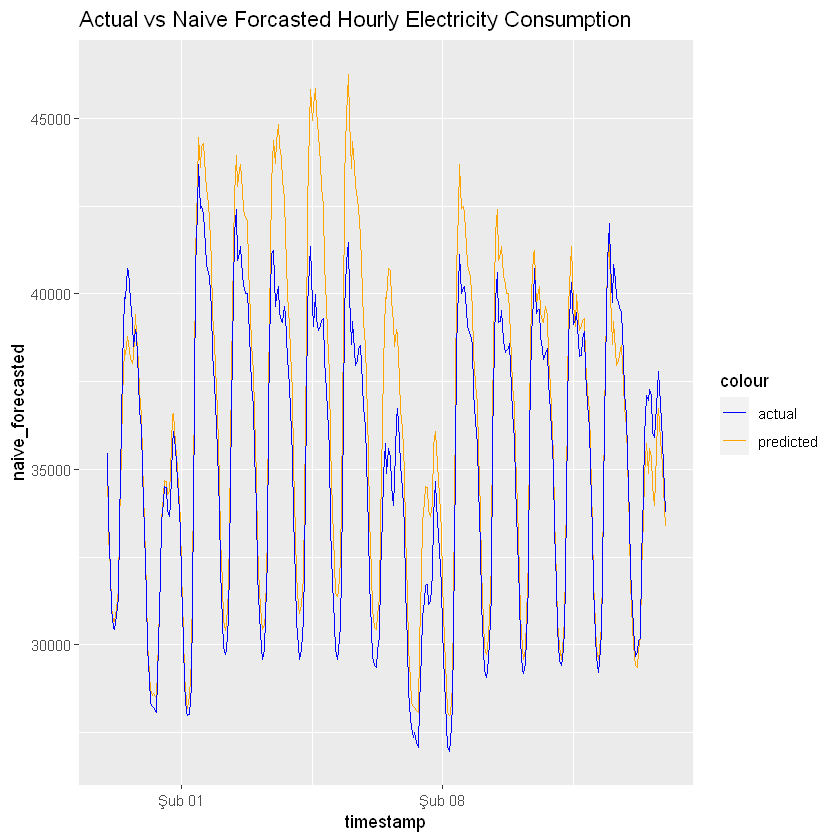

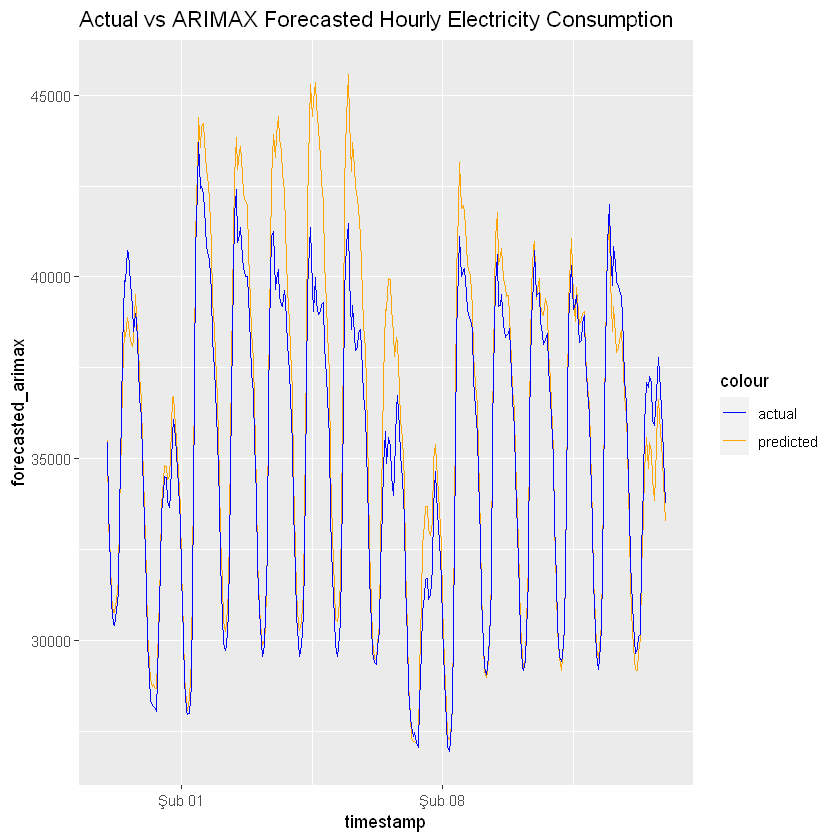

In [24]:
cols <- c("predicted" = "orange", "actual" = "blue")
ggplot() + 
  geom_line(data = consumption_and_temp[Date %between% as.Date(c("2021-01-30","2021-02-13"))], aes(x = timestamp, y = naive_forecasted,color = "predicted")) +  
  geom_line(data = consumption_and_temp[Date %between% as.Date(c("2021-01-30","2021-02-13"))], aes(x = timestamp, y = Consumption,color = "actual")) +
  labs(xlab = "Date", 
       title = 'Actual vs Naive Forcasted Hourly Electricity Consumption' ) +
  scale_color_manual(values = cols)

cols <- c("predicted" = "orange", "actual" = "blue")
ggplot() + 
  geom_line(data = consumption_and_temp[Date %between% as.Date(c("2021-01-30","2021-02-13"))], aes(x = timestamp, y = forecasted_arimax,color = "predicted")) +  
  geom_line(data = consumption_and_temp[Date %between% as.Date(c("2021-01-30","2021-02-13"))], aes(x = timestamp, y = Consumption,color = "actual")) +
  labs(xlab = "Date",
       title = 'Actual vs ARIMAX Forecasted Hourly Electricity Consumption' ) +
  scale_color_manual(values = cols)


## Conclusion and Future Works

As mentioned above, there are several approaches to create a forecast and we used two methods to understand which method should be used for electricity consumption values in this project. We tested our approaches using test data set which created from existed time series for electricity consumption values and choose least WMAPE value.

In the first days of submission 24 hour differencing technique was used. However high WMAPE values which indicates that this approach is not good enough for accurate predictions are obtained. The reason of getting bad results using 24 hour differencing technique is that when two days ahead forecasting is done, error of first day is added to prediction of second day. So 168 hour differencing is decided to use.

To get more accurate predictions, further outlier analysis can be done, GAM(Generalized Additive Models), linear regression or simple moving average methods can be used instead of ARIMAX models. Further test of different models can be useful. A better approach for using temperature values can be useful also.